# 07.3f: Kissing Cluster Geometric Analysis

**Goal:** Quantify the geometric structure of the kissing cluster.

We have 111 tokens that form a complete graph with all pairwise L∞ distances ≤ 2× ULP. They're packed into an extremely small region of 2560D space. This notebook analyzes:

1. **Effective dimensionality** (participation ratio from PCA)
2. **Principal axes of variation** (PCA eigenvectors)
3. **Component-wise variation** (which dimensions are active vs frozen)
4. **Shape characterization** (hypercube, ellipsoid, or something else?)
5. **Bounding box dimensions** (extent along each component)

**Key question:** What is the actual geometric structure of 111 tokens collapsed to within 2× ULP?

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Kissing cluster token IDs (from 07.3e)
KISSING_CLUSTER_FILE = "kissing_cluster_lat23_lon164.safetensors"
KISSING_CLUSTER_KEY = "token_ids"

# Gamma vectors
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma"

# Number of principal components to analyze in detail
N_PCS_DETAILED = 20

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading kissing cluster token IDs...")
kissing_data = load_file(data_dir / KISSING_CLUSTER_FILE)
kissing_ids = kissing_data[KISSING_CLUSTER_KEY]
n_tokens = len(kissing_ids)
print(f"  Kissing cluster size: {n_tokens:,} tokens")
print()

Loading kissing cluster token IDs...
  Kissing cluster size: 111 tokens



In [4]:
print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {gamma.dtype}")
print()

Loading gamma matrix...
  Shape: (151,936, 2,560)
  Dtype: torch.float32



In [5]:
# Extract vectors for kissing cluster
print("Extracting kissing cluster vectors...")
cluster_vectors = gamma[kissing_ids]
print(f"  Shape: {cluster_vectors.shape}")
print()

Extracting kissing cluster vectors...
  Shape: torch.Size([111, 2560])



## Step 2: Basic Statistics

In [6]:
print("Computing basic statistics...\n")

# Centroid
centroid = cluster_vectors.mean(dim=0)

# Center the cluster
centered = cluster_vectors - centroid

# Component-wise statistics
comp_min = cluster_vectors.min(dim=0)[0]
comp_max = cluster_vectors.max(dim=0)[0]
comp_range = comp_max - comp_min
comp_std = cluster_vectors.std(dim=0)

print(f"Centroid:")
print(f"  Norm: {torch.norm(centroid).item():.6f}")
print(f"  Mean component: {centroid.mean().item():.6e}")
print(f"  Component range: [{centroid.min().item():.6e}, {centroid.max().item():.6e}]")
print()

print(f"Component-wise variation:")
print(f"  Mean range: {comp_range.mean().item():.6e}")
print(f"  Max range: {comp_range.max().item():.6e}")
print(f"  Min range: {comp_range.min().item():.6e}")
print()

print(f"Component-wise std:")
print(f"  Mean std: {comp_std.mean().item():.6e}")
print(f"  Max std: {comp_std.max().item():.6e}")
print(f"  Min std: {comp_std.min().item():.6e}")
print()

Computing basic statistics...

Centroid:
  Norm: 0.370917
  Mean component: -5.844104e-05
  Component range: [-8.007812e-02, 4.980469e-02]

Component-wise variation:
  Mean range: 3.686251e-05
  Max range: 6.103516e-05
  Min range: 0.000000e+00

Component-wise std:
  Mean std: 4.208154e-06
  Max std: 1.632502e-05
  Min std: 0.000000e+00



## Step 3: Distance Statistics

In [7]:
print("Computing pairwise distance statistics...\n")

# Compute pairwise distances in different norms
v1 = cluster_vectors.unsqueeze(1)  # [n, 1, d]
v2 = cluster_vectors.unsqueeze(0)  # [1, n, d]
diff = v1 - v2  # [n, n, d]

# L2 (Euclidean)
l2_dist = torch.norm(diff, p=2, dim=2)

# L1 (Manhattan)
l1_dist = torch.norm(diff, p=1, dim=2)

# L∞ (Chebyshev)
l_inf_dist = torch.abs(diff).max(dim=2)[0]

# Extract upper triangle (excluding diagonal)
triu_indices = torch.triu_indices(n_tokens, n_tokens, offset=1)
l2_pairs = l2_dist[triu_indices[0], triu_indices[1]]
l1_pairs = l1_dist[triu_indices[0], triu_indices[1]]
l_inf_pairs = l_inf_dist[triu_indices[0], triu_indices[1]]

print(f"L2 (Euclidean) distances:")
print(f"  Min: {l2_pairs.min().item():.6e}")
print(f"  Max: {l2_pairs.max().item():.6e}")
print(f"  Mean: {l2_pairs.mean().item():.6e}")
print(f"  Median: {l2_pairs.median().item():.6e}")
print()

print(f"L1 (Manhattan) distances:")
print(f"  Min: {l1_pairs.min().item():.6e}")
print(f"  Max: {l1_pairs.max().item():.6e}")
print(f"  Mean: {l1_pairs.mean().item():.6e}")
print(f"  Median: {l1_pairs.median().item():.6e}")
print()

print(f"L∞ (Chebyshev) distances:")
print(f"  Min: {l_inf_pairs.min().item():.6e}")
print(f"  Max: {l_inf_pairs.max().item():.6e}")
print(f"  Mean: {l_inf_pairs.mean().item():.6e}")
print(f"  Median: {l_inf_pairs.median().item():.6e}")
print()

Computing pairwise distance statistics...

L2 (Euclidean) distances:
  Min: 7.450581e-09
  Max: 1.607329e-03
  Mean: 1.973609e-04
  Median: 8.546313e-05

L1 (Manhattan) distances:
  Min: 7.450581e-09
  Max: 6.000546e-02
  Mean: 5.919780e-03
  Median: 1.236625e-03

L∞ (Chebyshev) distances:
  Min: 7.450581e-09
  Max: 6.103516e-05
  Mean: 2.608917e-05
  Median: 3.051758e-05



## Step 4: Component Activity Analysis

Identify which components vary vs stay constant.

In [8]:
print("Analyzing component activity...\n")

# Define "active" as components with range > 1e-10 (above numerical noise)
ACTIVITY_THRESHOLD = 1e-10

active_mask = comp_range > ACTIVITY_THRESHOLD
n_active = active_mask.sum().item()
n_frozen = d - n_active

print(f"Component activity (threshold = {ACTIVITY_THRESHOLD:.0e}):")
print(f"  Active components: {n_active:,} ({n_active/d*100:.2f}%)")
print(f"  Frozen components: {n_frozen:,} ({n_frozen/d*100:.2f}%)")
print()

# Show most active components
top_k = 20
top_active_indices = torch.argsort(comp_range, descending=True)[:top_k]
print(f"Top {top_k} most active components:")
for i, idx in enumerate(top_active_indices):
    print(f"  {i+1}. Component {idx.item()}: range = {comp_range[idx].item():.6e}, std = {comp_std[idx].item():.6e}")
print()

Analyzing component activity...

Component activity (threshold = 1e-10):
  Active components: 2,180 (85.16%)
  Frozen components: 380 (14.84%)

Top 20 most active components:
  1. Component 2114: range = 6.103516e-05, std = 5.819474e-06
  2. Component 1788: range = 6.103516e-05, std = 6.500505e-06
  3. Component 717: range = 6.103516e-05, std = 5.793201e-06
  4. Component 1541: range = 6.103516e-05, std = 5.032239e-06
  5. Component 324: range = 6.103516e-05, std = 6.500505e-06
  6. Component 6: range = 6.103516e-05, std = 6.500505e-06
  7. Component 325: range = 6.103516e-05, std = 6.500505e-06
  8. Component 2544: range = 6.103516e-05, std = 5.793201e-06
  9. Component 1542: range = 6.103516e-05, std = 5.032239e-06
  10. Component 2535: range = 6.103516e-05, std = 5.819474e-06
  11. Component 327: range = 6.103516e-05, std = 5.032239e-06
  12. Component 17: range = 6.103516e-05, std = 6.500505e-06
  13. Component 1885: range = 6.103516e-05, std = 5.032239e-06
  14. Component 2531: ra

## Step 5: PCA

In [9]:
print("Performing PCA...\n")

# Compute covariance matrix
cov = (centered.T @ centered) / (n_tokens - 1)

print(f"Covariance matrix: {cov.shape}")
print()

# Eigendecomposition
print("Computing eigendecomposition...")
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort by descending eigenvalue
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Compute variance explained
total_var = eigenvalues.sum()
var_explained = eigenvalues / total_var
var_cumulative = torch.cumsum(var_explained, dim=0)

print(f"  ✓ Computed {d:,} eigenvalues")
print()

print(f"Total variance: {total_var.item():.6e}")
print()

Performing PCA...

Covariance matrix: torch.Size([2560, 2560])

Computing eigendecomposition...
  ✓ Computed 2,560 eigenvalues

Total variance: 5.474510e-08



## Step 6: Participation Ratio

In [10]:
print("Computing participation ratio...\n")

# Participation ratio: PR = (sum λ_i)^2 / sum(λ_i^2)
# Measures effective dimensionality
sum_eigenvalues = eigenvalues.sum()
sum_eigenvalues_sq = (eigenvalues ** 2).sum()
participation_ratio = (sum_eigenvalues ** 2) / sum_eigenvalues_sq

print(f"Participation ratio: {participation_ratio.item():.2f}")
print(f"  (Effective dimensionality of variation)")
print()

print(f"As percentage of full space: {participation_ratio.item()/d*100:.2f}%")
print()

# Also compute normalized PR (max = number of tokens - 1)
max_pr = n_tokens - 1  # Maximum possible for n_tokens points
normalized_pr = participation_ratio / max_pr
print(f"Normalized PR (relative to {max_pr} max): {normalized_pr.item():.2%}")
print()

Computing participation ratio...

Participation ratio: 7.67
  (Effective dimensionality of variation)

As percentage of full space: 0.30%

Normalized PR (relative to 110 max): 6.98%



## Step 7: Eigenvalue Spectrum

In [11]:
print(f"Eigenvalue spectrum (top {N_PCS_DETAILED} PCs):\n")

for i in range(min(N_PCS_DETAILED, len(eigenvalues))):
    ev = eigenvalues[i].item()
    var_pct = var_explained[i].item() * 100
    cum_pct = var_cumulative[i].item() * 100
    print(f"  PC{i+1:2d}: λ = {ev:.6e}  |  Var: {var_pct:6.2f}%  |  Cumulative: {cum_pct:6.2f}%")

print()

# Find how many PCs needed for 90%, 95%, 99% variance
for threshold in [0.90, 0.95, 0.99]:
    n_pcs = (var_cumulative >= threshold).nonzero()[0].item() + 1
    print(f"PCs needed for {threshold*100:.0f}% variance: {n_pcs}")

print()

Eigenvalue spectrum (top 20 PCs):

  PC 1: λ = 1.380679e-08  |  Var:  25.22%  |  Cumulative:  25.22%
  PC 2: λ = 8.236530e-09  |  Var:  15.05%  |  Cumulative:  40.27%
  PC 3: λ = 7.216102e-09  |  Var:  13.18%  |  Cumulative:  53.45%
  PC 4: λ = 7.069138e-09  |  Var:  12.91%  |  Cumulative:  66.36%
  PC 5: λ = 2.905665e-09  |  Var:   5.31%  |  Cumulative:  71.67%
  PC 6: λ = 2.697710e-09  |  Var:   4.93%  |  Cumulative:  76.59%
  PC 7: λ = 1.893765e-09  |  Var:   3.46%  |  Cumulative:  80.05%
  PC 8: λ = 1.882314e-09  |  Var:   3.44%  |  Cumulative:  83.49%
  PC 9: λ = 1.619049e-09  |  Var:   2.96%  |  Cumulative:  86.45%
  PC10: λ = 1.168493e-09  |  Var:   2.13%  |  Cumulative:  88.58%
  PC11: λ = 1.149962e-09  |  Var:   2.10%  |  Cumulative:  90.68%
  PC12: λ = 9.422384e-10  |  Var:   1.72%  |  Cumulative:  92.41%
  PC13: λ = 5.427022e-10  |  Var:   0.99%  |  Cumulative:  93.40%
  PC14: λ = 4.272022e-10  |  Var:   0.78%  |  Cumulative:  94.18%
  PC15: λ = 3.466268e-10  |  Var:   0.63%

## Step 8: Visualize Eigenvalue Spectrum

Creating eigenvalue spectrum plots...



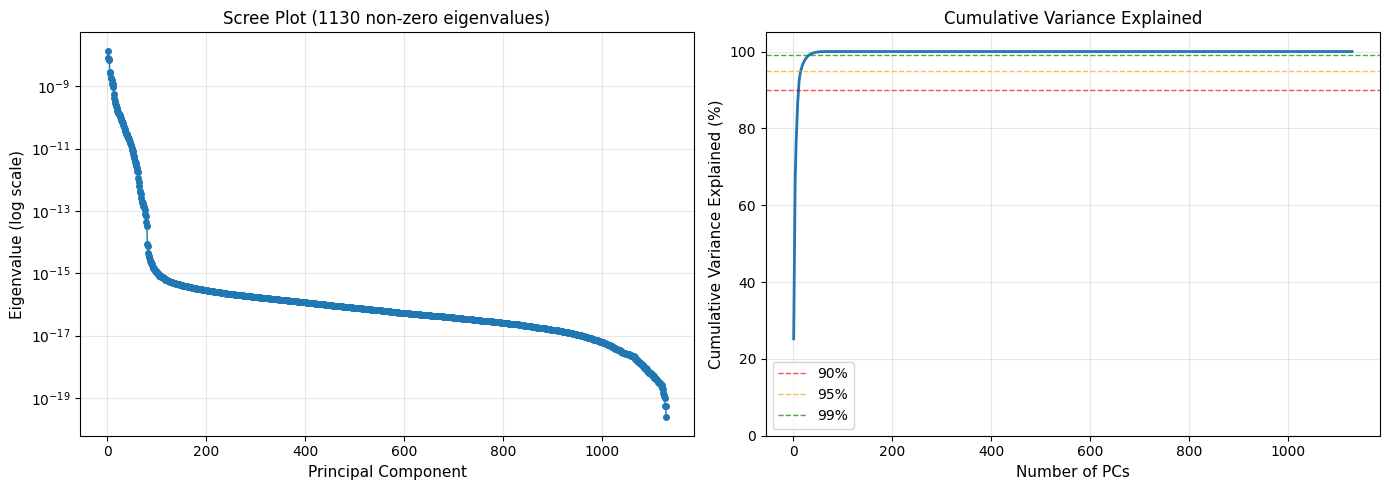

✓ Eigenvalue spectrum plotted.



In [12]:
print("Creating eigenvalue spectrum plots...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Plot 1: Scree plot (log scale)
ax = axes[0]
eigenvalues_np = eigenvalues.cpu().numpy()
# Only plot non-zero eigenvalues
nonzero_mask = eigenvalues_np > 1e-20
nonzero_eigs = eigenvalues_np[nonzero_mask]
n_nonzero = len(nonzero_eigs)

ax.plot(range(1, n_nonzero + 1), nonzero_eigs, 'o-', markersize=4, linewidth=1)
ax.set_yscale('log')
ax.set_xlabel('Principal Component', fontsize=11)
ax.set_ylabel('Eigenvalue (log scale)', fontsize=11)
ax.set_title(f'Scree Plot ({n_nonzero} non-zero eigenvalues)', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 2: Cumulative variance explained
ax = axes[1]
var_cumulative_np = var_cumulative.cpu().numpy()
ax.plot(range(1, n_nonzero + 1), var_cumulative_np[:n_nonzero] * 100, linewidth=2)
ax.axhline(90, color='red', linestyle='--', linewidth=1, alpha=0.7, label='90%')
ax.axhline(95, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='95%')
ax.axhline(99, color='green', linestyle='--', linewidth=1, alpha=0.7, label='99%')
ax.set_xlabel('Number of PCs', fontsize=11)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=11)
ax.set_title('Cumulative Variance Explained', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("✓ Eigenvalue spectrum plotted.")
print()

## Step 9: Visualize Component Range Distribution

Creating component range distribution...



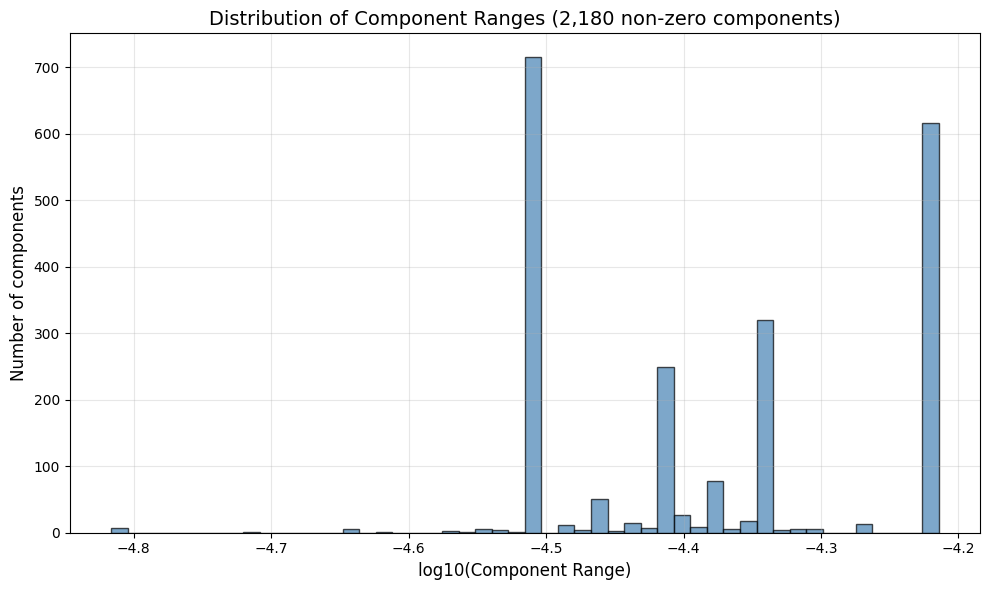

✓ Component range distribution plotted.



In [13]:
print("Creating component range distribution...\n")

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

comp_range_np = comp_range.cpu().numpy()
# Filter to non-zero ranges for visualization
nonzero_ranges = comp_range_np[comp_range_np > 1e-20]

ax.hist(np.log10(nonzero_ranges), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('log10(Component Range)', fontsize=12)
ax.set_ylabel('Number of components', fontsize=12)
ax.set_title(f'Distribution of Component Ranges ({len(nonzero_ranges):,} non-zero components)', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Component range distribution plotted.")
print()

## Step 10: Shape Characterization

Compare L1, L2, L∞ distance ratios to infer shape.

In [14]:
print("Characterizing cluster shape...\n")

# Compute ratios of different distance metrics
# For a hypercube: L∞ ≈ L2 ≈ L1/√d
# For a hypersphere: L2 is dominant, L∞ << L2

l2_mean = l2_pairs.mean().item()
l1_mean = l1_pairs.mean().item()
l_inf_mean = l_inf_pairs.mean().item()

# Effective dimensionality from distance ratios
# For d-dimensional uniform distribution: L1 ≈ L2 * √d
effective_dim_from_distances = (l1_mean / l2_mean) ** 2 if l2_mean > 0 else 0

print(f"Distance metric ratios:")
print(f"  L1 / L2: {l1_mean / l2_mean if l2_mean > 0 else 0:.2f}")
print(f"  L∞ / L2: {l_inf_mean / l2_mean if l2_mean > 0 else 0:.2f}")
print(f"  L1 / L∞: {l1_mean / l_inf_mean if l_inf_mean > 0 else 0:.2f}")
print()

print(f"Effective dimensionality from L1/L2 ratio: {effective_dim_from_distances:.1f}")
print()

print("Shape interpretation:")
if l_inf_mean / l2_mean > 0.8:
    print("  → Hypercube-like (L∞ ≈ L2)")
elif l_inf_mean / l2_mean < 0.3:
    print("  → Hypersphere-like (L∞ << L2)")
else:
    print("  → Intermediate geometry")
print()

Characterizing cluster shape...

Distance metric ratios:
  L1 / L2: 29.99
  L∞ / L2: 0.13
  L1 / L∞: 226.91

Effective dimensionality from L1/L2 ratio: 899.7

Shape interpretation:
  → Hypersphere-like (L∞ << L2)



## Summary

In [15]:
print("=" * 60)
print("KISSING CLUSTER GEOMETRY SUMMARY")
print("=" * 60)
print()
print(f"Cluster size: {n_tokens:,} tokens")
print(f"Embedding dimension: {d:,}")
print()
print(f"EFFECTIVE DIMENSIONALITY:")
print(f"  Participation ratio: {participation_ratio.item():.2f}")
print(f"  As % of full space: {participation_ratio.item()/d*100:.2f}%")
print(f"  From distance ratios: {effective_dim_from_distances:.1f}")
print()
print(f"COMPONENT ACTIVITY:")
print(f"  Active components (range > 1e-10): {n_active:,} ({n_active/d*100:.2f}%)")
print(f"  Frozen components: {n_frozen:,} ({n_frozen/d*100:.2f}%)")
print()
print(f"VARIANCE EXPLAINED:")
pc_90 = (var_cumulative >= 0.90).nonzero()[0].item() + 1
pc_99 = (var_cumulative >= 0.99).nonzero()[0].item() + 1
print(f"  90% variance: {pc_90} PCs")
print(f"  99% variance: {pc_99} PCs")
print()
print(f"PAIRWISE DISTANCES (mean):")
print(f"  L2 (Euclidean): {l2_mean:.6e}")
print(f"  L1 (Manhattan): {l1_mean:.6e}")
print(f"  L∞ (Chebyshev): {l_inf_mean:.6e}")
print()
print("=" * 60)

KISSING CLUSTER GEOMETRY SUMMARY

Cluster size: 111 tokens
Embedding dimension: 2,560

EFFECTIVE DIMENSIONALITY:
  Participation ratio: 7.67
  As % of full space: 0.30%
  From distance ratios: 899.7

COMPONENT ACTIVITY:
  Active components (range > 1e-10): 2,180 (85.16%)
  Frozen components: 380 (14.84%)

VARIANCE EXPLAINED:
  90% variance: 11 PCs
  99% variance: 32 PCs

PAIRWISE DISTANCES (mean):
  L2 (Euclidean): 1.973609e-04
  L1 (Manhattan): 5.919780e-03
  L∞ (Chebyshev): 2.608917e-05

